### Load the data

In [1]:
import pandas as pd
sales = pd.read_csv('All_customer_8-17-2021.csv',encoding='unicode_escape')
sales.head(2)

,Subsidiary,Trans. Type,End Customer,Bill to Customer Category,Ship Date,Trans. Number,Trans. Date,Posting Period,Sales Order Number,Sales Order Type,...,Sales Rep Location,Destination,Direct,List Price,End Customer Parent Name,Customer Parent Name,End Customer Revenue_Line Amt,End Customer Revenue_List Price,Customer Revenue_Line Amt,Customer Revenue_List Price
0,"Arista Networks, Inc.",Invoice,9218 Grand Canyon University,Authorized Partner,2020-07-30,185398,2020-07-30,Jul 2020,158712,Regular Order,...,United States,United States,0,2380.0,Grand Canyon University,"Enterprise Networking Solutions, Inc.",79064,208109,952081,2854740
1,"Arista Networks, Inc.",Invoice,2040 Phoenix Nap,End Customer,2020-11-10,198436,2020-11-10,Nov 2020,169142,Regular Order,...,United States,United States,1,75990.0,Phoenix Nap,Phoenix Nap,3071580,9480958,0,0


In [2]:
# total number of rows in the dataset
len(sales)

94556

In [3]:
# total number of transactions
len(sales['Sales Order Number'].unique())

24450

In [4]:
len(sales.columns)

64

In [2]:
continent = pd.read_csv("Country-Continent mapping.csv")
continent.head(2)

,Country,Continent
0,Afghanistan,Asia
1,Albania,Europe


In [6]:
# Check the total number of country that continent file covers
len(continent['Country'].unique())

172

In [3]:
check=[]
for i in sales['Destination'].unique():
    if i in list(continent['Country']):
        check.append('Exist')
    else:
        check.append('No Exist')

In [4]:
# all the country listed in the continent file exist in the sales['Destination']
set(check)

{'Exist', 'No Exist'}

### Grouping destination countries to continenets

In [5]:
continent.columns=['Destination','Continent']
continent.head(2)

,Destination,Continent
0,Afghanistan,Asia
1,Albania,Europe


In [6]:
# merge the 2 datasets
sales2 = pd.merge(sales, continent, on='Destination',how='left')
sales2.head(2)

,Subsidiary,Trans. Type,End Customer,Bill to Customer Category,Ship Date,Trans. Number,Trans. Date,Posting Period,Sales Order Number,Sales Order Type,...,Destination,Direct,List Price,End Customer Parent Name,Customer Parent Name,End Customer Revenue_Line Amt,End Customer Revenue_List Price,Customer Revenue_Line Amt,Customer Revenue_List Price,Continent
0,"Arista Networks, Inc.",Invoice,9218 Grand Canyon University,Authorized Partner,2020-07-30,185398,2020-07-30,Jul 2020,158712,Regular Order,...,United States,0,2380.0,Grand Canyon University,"Enterprise Networking Solutions, Inc.",79064,208109,952081,2854740,North America
1,"Arista Networks, Inc.",Invoice,2040 Phoenix Nap,End Customer,2020-11-10,198436,2020-11-10,Nov 2020,169142,Regular Order,...,United States,1,75990.0,Phoenix Nap,Phoenix Nap,3071580,9480958,0,0,North America


In [11]:
len(sales2.columns)

65

In [12]:
len(sales2.Continent)

94556

In [7]:
from collections import Counter
Counter(sales2.Continent)

Counter({'North America': 56347,
         'Europe': 19241,
         'Oceania': 1660,
         'Asia': 22643,
         'South America': 459,
         nan: 7,
         'Africa': 617})

### Only Include Indirect Sales

In [8]:
sales2['Direct'].unique()

array([0, 1], dtype=int64)

In [9]:
# only get the indirect sales from the dataset
sales3 = sales2.loc[sales2['Direct'] != 1,:]
sales3.head(2)

,Subsidiary,Trans. Type,End Customer,Bill to Customer Category,Ship Date,Trans. Number,Trans. Date,Posting Period,Sales Order Number,Sales Order Type,...,Destination,Direct,List Price,End Customer Parent Name,Customer Parent Name,End Customer Revenue_Line Amt,End Customer Revenue_List Price,Customer Revenue_Line Amt,Customer Revenue_List Price,Continent
0,"Arista Networks, Inc.",Invoice,9218 Grand Canyon University,Authorized Partner,2020-07-30,185398,2020-07-30,Jul 2020,158712,Regular Order,...,United States,0,2380.0,Grand Canyon University,"Enterprise Networking Solutions, Inc.",79064,208109,952081,2854740,North America
3,"Arista Networks, Inc.",Invoice,15547 MGF,Authorized Partner,2020-07-21,184258,2020-07-21,Jul 2020,158306,Regular Order,...,United States,0,15990.0,MGF,Presidio Networked Solutions,20346,45706,27998150,69429454,North America


In [16]:
sales3.Direct.unique()

array([ 0., nan])

In [17]:
len(sales3)

76020

In [10]:
# only get the direct sales from the dataset
sales4 = sales2.loc[sales2['Direct'] != 0,:]
len(sales4)

19322

In [191]:
sales4.to_csv("z-All_customer-DirectSalesOnly.csv")

## Per Sales Order

Sales: original data <br>
Sales2: includes the continents <br>
Sales3: only inlucde the indirect sales <br>
Sales4: only include the direct sales

Predictive features:
1. **revenue per end customer (sum of list price for each end customer)**
2. Continent of the reseller
3. **sales rep email (average sales order) #regarded null value as a category at this moment**

Target:
discount: average discount per sales order
** adjusted weighted discount => used for prediction
It's not in all_customer, the adjusted weighted discount is based on destination and item, we don't have to use it here because we have considered another destination form here.


#### Discount

In [11]:
order_discount = sales.groupby("Sales Order Number")["DISCOUNT"].agg(["mean"])
order_discount

,mean
Sales Order Number,
63797,0.72000
74072,0.72472
88272,0.97200
88273,0.97200
88274,0.97200
...,...
199944,0.25000
199945,0.16000
199946,0.33330


In [12]:
# exclude the direct sales - use order_discount2 to get the indirect order number ONLY
order_discount2 = sales3.groupby("Sales Order Number")["DISCOUNT"].agg(["mean"])
order_discount2

,mean
Sales Order Number,
107451,0.4500
115174,0.5000
116169,0.6900
116390,0.6900
116393,0.6900
...,...
199940,0.5891
199942,0.5891
199945,0.1600


#### End customer revenue

In [13]:
end_customer_revenue = sales.groupby("Sales Order Number")["End Customer Revenue_List Price"].unique()
end_customer_revenue

Sales Order Number
63797      [2788560]
74072      [2788560]
88272     [28614080]
88273     [28614080]
88274     [28614080]
             ...    
199944    [19096710]
199945       [17407]
199946       [35998]
199948       [54720]
199958       [12240]
Name: End Customer Revenue_List Price, Length: 26041, dtype: object

In [14]:
end_customer_revenue = [i[0] for i in end_customer_revenue]
end_customer_revenue = pd.DataFrame(end_customer_revenue, index = order_discount.index, columns = ["End Customer Revenue"])
end_customer_revenue

,End Customer Revenue
Sales Order Number,
63797,2788560
74072,2788560
88272,28614080
88273,28614080
88274,28614080
...,...
199944,19096710
199945,17407
199946,35998


In [15]:
end_customer_revenue2 = [end_customer_revenue['End Customer Revenue'][i] for i in order_discount2.index.tolist()]
end_customer_revenue2 = pd.DataFrame(end_customer_revenue2, index = order_discount2.index, columns = ["End Customer Revenue"])
end_customer_revenue2

,End Customer Revenue
Sales Order Number,
107451,253640
115174,12784764
116169,26456
116390,40801
116393,26456
...,...
199940,8003232
199942,8003232
199945,17407


In [16]:
KMean_Input_salerModel = pd.concat([end_customer_revenue2, order_discount2], axis=1)

from sklearn.preprocessing import MinMaxScaler
import numpy as np

revenue = np.array(KMean_Input_salerModel["End Customer Revenue"]).reshape(-1,1)
scaler = MinMaxScaler()
norm_revenue = scaler.fit_transform(revenue)
KMean_Input_salerModel['End Customer Revenue Norm'] = norm_revenue

KMean_Input_salerModel.columns = ['End_Customer_Revenue_original','Average_Discount_Per_Order','End_Customer_Revenue']
KMean_Input_salerModel

,End_Customer_Revenue_original,Average_Discount_Per_Order,End_Customer_Revenue
Sales Order Number,,,
107451,253640,0.4500,0.005286
115174,12784764,0.5000,0.266551
116169,26456,0.6900,0.000550
116390,40801,0.6900,0.000849
116393,26456,0.6900,0.000550
...,...,...,...
199940,8003232,0.5891,0.166859
199942,8003232,0.5891,0.166859
199945,17407,0.1600,0.000361


In [17]:
KMean_Input_salerModel.to_csv('z-SalesOrder_Kcluster_Input_8-17-2021.csv')

#### Continent

In [24]:
order_continent = sales3.groupby("Sales Order Number")["Continent"].unique()
order_continent = [i[0] for i in order_continent]
order_continent = pd.DataFrame(order_continent, index = order_discount2.index, columns = ["Continent"])
order_continent

,Continent
Sales Order Number,
107451,North America
115174,North America
116169,Asia
116393,Asia
121673,North America
...,...
199940,North America
199942,North America
199945,North America


#### Sales Rep (Email)

In [29]:
# group the original data by email, sales order and average discount per order
df1 = sales.groupby(['Email','Sales Order Number'])['DISCOUNT'].mean()
df1

Email                                                                                                                                                                                                            Sales Order Number
4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199@qq.com;lvss@dhcc.com.cn;huangzhiliang@dhcc.com.cn;wang_lei@dhcc.com.cn;gaojun@dhcc.com.cn;anl-accounts.receivable@arista.com; atan@arista.com,gaojun@dhcc.com.cn  170741                0.720000
                                                                                                                                                                                                                 171190                0.878518
                                                                                                                                                                                                                 177934                0.912167
                                                    

In [30]:
df1=pd.DataFrame(df1)
df1['Email']= [i[0] for i in df1.index]
df1['Sales Order Number'] = [i[1] for i in df1.index]
df1 = df1.reset_index(drop=True)
df1

,DISCOUNT,Email,Sales Order Number
0,0.720000,4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199...,170741
1,0.878518,4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199...,171190
2,0.912167,4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199...,177934
3,0.932300,4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199...,178235
4,0.928900,4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199...,178921
...,...,...,...
24453,0.572175,"zirmed.invoicecapture@waystar.com, bolanle@ari...",193925
24454,0.580000,"zirmed.invoicecapture@waystar.com, bolanle@ari...",198034
24455,0.816000,zkhalid@elasalle.com,156392
24456,0.556900,zuojing@linkteltech.com;anl-accounts.receivabl...,163275


In [27]:
# regroup the df1 to calculate the average discount per each email
df2 = df1.groupby(['Email'])['DISCOUNT'].mean()
df2

Email
4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199@qq.com;lvss@dhcc.com.cn;huangzhiliang@dhcc.com.cn;wang_lei@dhcc.com.cn;gaojun@dhcc.com.cn;anl-accounts.receivable@arista.com; atan@arista.com,gaojun@dhcc.com.cn    0.857387
8882139185@onlinecapturecenter.com                                                                                                                                                                                 0.729535
8longs@sg.ibm.com;8tinhkf@sg.ibm.com; anl-accounts.receivable@arista.com; 8izzah@sg.ibm.com; sushenoy@in.ibm.com                                                                                                   0.580000
8longs@sg.ibm.com;8tinhkf@sg.ibm.com; anl-accounts.receivable@arista.com; atan@arista.com; 8izzah@sg.ibm.com; sushenoy@in.ibm.com                                                                                  0.356667
ACASIN-Operations@acapacific.com.sg;anl-accounts.receivable@arista.com                                            

In [28]:
email = df2.index
average_discount = df2.values
email

Index(['4022494@qq.com;qiaosiyu@dhcc.com.cn;1428866199@qq.com;lvss@dhcc.com.cn;huangzhiliang@dhcc.com.cn;wang_lei@dhcc.com.cn;gaojun@dhcc.com.cn;anl-accounts.receivable@arista.com; atan@arista.com,gaojun@dhcc.com.cn',
       '8882139185@onlinecapturecenter.com',
       '8longs@sg.ibm.com;8tinhkf@sg.ibm.com; anl-accounts.receivable@arista.com; 8izzah@sg.ibm.com; sushenoy@in.ibm.com',
       '8longs@sg.ibm.com;8tinhkf@sg.ibm.com; anl-accounts.receivable@arista.com; atan@arista.com; 8izzah@sg.ibm.com; sushenoy@in.ibm.com',
       'ACASIN-Operations@acapacific.com.sg;anl-accounts.receivable@arista.com',
       'ACCOUNTING@rahisystems.com, ap@rahisystems.com',
       'AM.AccountsPayable@global.ntt,renee.edenfield@global.ntt',
       'AM.Finance.AccountsPayable@dimensiondata.com',
       'AM.accountspayable@global.ntt',
       'AP-Inventory@synnex.com, linday@synnex.com',
       ...
       'yuni.marlina@computradetech.com;cti.payable@computradetech.com;anl-accounts.receivable@arista.com;acco

In [28]:
dd = pd.DataFrame(email)
dd['Average_Discount_Per_Sales_Rep'] = average_discount
dd

,Email,Average_Discount_Per_Sales_Rep
0,Brian@arista.com,0.564167
1,Jfallt@arista.com,0.381640
2,NULL Value,0.547670
3,a.shevchenko@arista.com,0.725860
4,abchadha@arista.com,0.595314
...,...,...
266,xhd@arista.com,0.900552
267,yj@arista.com,0.345870
268,ytakahashi@arista.com,0.319784
269,zmikram@arista.com,0.392483


In [29]:
order_email = sales3.groupby("Sales Order Number")["Email"].unique()
order_email = [i[0] for i in order_email]
order_email = pd.DataFrame(order_email, index = order_discount2.index, columns = ["Email"])
order_email

,Email
Sales Order Number,
107451,ronkim@arista.com
115174,ronkim@arista.com
121673,intazh@arista.com
122157,ronkim@arista.com
125813,ronkim@arista.com
...,...
180183,ivanguoh@arista.com
180184,ivanguoh@arista.com
180185,ivanguoh@arista.com


In [30]:
# map the average discount to each email
order_email_encoded = pd.merge(order_email, dd, on='Email', how='left')
order_email_encoded['Sales Order Number'] = order_email.index
order_email_encoded.set_index(['Sales Order Number'],inplace=True,drop=True)
order_email_encoded

,Email,Average_Discount_Per_Sales_Rep
Sales Order Number,,
107451,ronkim@arista.com,0.531218
115174,ronkim@arista.com,0.531218
121673,intazh@arista.com,0.379636
122157,ronkim@arista.com,0.531218
125813,ronkim@arista.com,0.531218
...,...,...
180183,ivanguoh@arista.com,0.532165
180184,ivanguoh@arista.com,0.532165
180185,ivanguoh@arista.com,0.532165


In [31]:
order_email_encoded.to_csv('z-Encoded_Sales_Rep_Email_Per_Order_06-11-21.csv')

#### Check if there's no multiple continent for one sales order

In [32]:
multipleContinent = 0
for index, i in zip(order_continent.index, order_continent):
    if len(i) > 1:
        print(index, i)
        multipleContinent += 1
print(multipleContinent)

107451 Continent
1


#### Combined data ( Revenue + Continent + Encoded Sales Rep Email)

In [33]:
OrderModel = pd.concat([end_customer_revenue2, order_continent, order_email_encoded['Average_Discount_Per_Sales_Rep'], order_discount2], axis=1)
# the first 3 columns are the predictive variables and the Discount is the target that we aims to predict
OrderModel.columns=['End_Customer_Revenue','Continent','Average_Discount_Per_Sales_Rep','Average_Discount_Per_Order']
Not_normalized_revenue = OrderModel['End_Customer_Revenue']
OrderModel

,End_Customer_Revenue,Continent,Average_Discount_Per_Sales_Rep,Average_Discount_Per_Order
Sales Order Number,,,,
107451,240780,North America,0.531218,0.4500
115174,7656869,North America,0.531218,0.5000
121673,742958,North America,0.379636,0.4500
122157,240780,North America,0.531218,0.4550
125813,4020718,North America,0.531218,0.5000
...,...,...,...,...
180183,19523698,Asia,0.532165,0.5922
180184,19523698,Asia,0.532165,0.5922
180185,19523698,Asia,0.532165,0.5922


In [34]:
OrderModel.to_csv("z-OrderModel_RawData.csv")

#### Normalize the revenue: rescale to range(0,1)

In [36]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

revenue = np.array(OrderModel["End_Customer_Revenue"]).reshape(-1,1)
scaler = MinMaxScaler()
norm_revenue = scaler.fit_transform(revenue)
norm_revenue

array([[4.93336730e-03],
       [1.56950598e-01],
       [1.52271635e-02],
       ...,
       [4.00200441e-01],
       [3.72345503e-03],
       [2.38436247e-04]])

In [37]:
OrderModel["End_Customer_Revenue"] = norm_revenue
OrderModel.head(2)

,End_Customer_Revenue,Continent,Average_Discount_Per_Sales_Rep,Average_Discount_Per_Order
Sales Order Number,,,,
107451,0.004933,North America,0.531218,0.45
115174,0.156951,North America,0.531218,0.50


#### Create dummy variables for continent using one hot encoding

In [38]:
OrderModel = pd.get_dummies(OrderModel, columns = ["Continent"])
OrderModel.head(3)

,End_Customer_Revenue,Average_Discount_Per_Sales_Rep,Average_Discount_Per_Order,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
Sales Order Number,,,,,,,,,
107451,0.004933,0.531218,0.45,0,0,0,1,0,0
115174,0.156951,0.531218,0.50,0,0,0,1,0,0
121673,0.015227,0.379636,0.45,0,0,0,1,0,0


In [39]:
OrderModel.to_csv("z-OrderModel_NormalizedData.csv")

### 1. Linear Regression Model - Revenue Only

In [40]:
from sklearn.linear_model import LinearRegression
OrderModel_y = OrderModel['Average_Discount_Per_Order']
OrderModel_X_revenue = OrderModel['End_Customer_Revenue']
OrderModel_X_revenue.head(2)

,End_Customer_Revenue
Sales Order Number,
107451,0.004933
115174,0.156951


In [41]:
ORDERreg0 = LinearRegression()
ORDERreg0.fit(OrderModel_X_revenue, OrderModel_y)
ORDERy_pred0 = ORDERreg0.predict(OrderModel_X_revenue)
ORDERreg0.score(OrderModel_X_revenue, OrderModel_y) # R2

0.08559152777523871

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(OrderModel_y, ORDERy_pred0)

0.03919759458127642

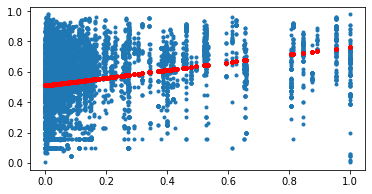

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(OrderModel_X_revenue['End_Customer_Revenue'], OrderModel_y, ".")
plt.plot(OrderModel_X_revenue['End_Customer_Revenue'], ORDERy_pred0, "r.")

In [44]:
#### Confidence interval

# calculate the standard deviation of y-pred values
ORDERy_pred_std0 = np.sqrt(sum((ORDERy_pred0-OrderModel_y)**2)/(len(OrderModel_y)-2))
ORDERy_pred_upper0 = ORDERy_pred0 + 1.036*ORDERy_pred_std0
ORDERy_pred_lower0 = ORDERy_pred0 - 1.036*ORDERy_pred_std0 
ORDERy_pred_upper0

array([0.71637193, 0.75496431, 0.7189852 , ..., 0.81671776, 0.71606477,
       0.71518004])

In [45]:
ORDERy_pred0

array([0.51124613, 0.54983851, 0.5138594 , ..., 0.61159196, 0.51093897,
       0.51005424])

In [47]:
OrderModel_Interval0 = OrderModel[['End_Customer_Revenue','Average_Discount_Per_Order']]
OrderModel_Interval0['End_Customer_Revenue-Original'] = Not_normalized_revenue
OrderModel_Interval0['Predicted_Average_Discount_Per_Order'] = ORDERy_pred0
OrderModel_Interval0['Predicted_Lower_Average_Discount_Per_Order'] = ORDERy_pred_lower0
OrderModel_Interval0['Predicted_Upper_Average_Discount_Per_Order'] = ORDERy_pred_upper0
OrderModel_Interval0.head(3)

<ipython-input-47-ad1bc1768ffc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OrderModel_Interval0['End_Customer_Revenue-Original'] = Not_normalized_revenue
<ipython-input-47-ad1bc1768ffc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OrderModel_Interval0['Predicted_Average_Discount_Per_Order'] = ORDERy_pred0
<ipython-input-47-ad1bc1768ffc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,End_Customer_Revenue,Average_Discount_Per_Order,End_Customer_Revenue-Original,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order
Sales Order Number,,,,,,
107451,0.004933,0.45,240780,0.511246,0.306120,0.716372
115174,0.156951,0.50,7656869,0.549839,0.344713,0.754964
121673,0.015227,0.45,742958,0.513859,0.308734,0.718985


In [48]:
# if the predicted disoucnt > upper bond then it will be an outlier
outlier0=[]
for i in range(0,len(ORDERy_pred_upper0)):
    if OrderModel_Interval0['Average_Discount_Per_Order'].tolist()[i] > ORDERy_pred_upper0[i]:
        outlier0.append(1)
    else:
        outlier0.append(0)
outlier0

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


In [49]:
OrderModel_Interval0['Sales_Order_Outlier'] = outlier0
OrderModel_Interval0.head(2)

<ipython-input-49-6024994785b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OrderModel_Interval0['Sales_Order_Outlier'] = outlier0


,End_Customer_Revenue,Average_Discount_Per_Order,End_Customer_Revenue-Original,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order,Sales_Order_Outlier
Sales Order Number,,,,,,,
107451,0.004933,0.45,240780,0.511246,0.306120,0.716372,0
115174,0.156951,0.50,7656869,0.549839,0.344713,0.754964,0


In [50]:
OrderModel_Interval0.to_csv("z-OrderModelResults_RevenueOnly.csv")

### 2. Linear Regression Model - without sales rep email (average discount per sales rep)

In [51]:
from sklearn.linear_model import LinearRegression
OrderModel_y = OrderModel['Average_Discount_Per_Order']
OrderModel_X2 = OrderModel.loc[:,OrderModel.columns !='Average_Discount_Per_Order']
OrderModel_X1 = OrderModel_X2.loc[:,OrderModel_X2.columns !='Average_Discount_Per_Sales_Rep']
OrderModel_X1.head(2)

,End_Customer_Revenue,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
Sales Order Number,,,,,,,
107451,0.004933,0,0,0,1,0,0
115174,0.156951,0,0,0,1,0,0


In [52]:
ORDERreg1 = LinearRegression()
ORDERreg1.fit(OrderModel_X1, OrderModel_y)
ORDERy_pred1 = ORDERreg1.predict(OrderModel_X1)
ORDERreg1.score(OrderModel_X1, OrderModel_y) # R2

0.09144756268495302

In [53]:
from sklearn.metrics import mean_squared_error
mean_squared_error(OrderModel_y, ORDERy_pred1)

0.038946566196022825

In [54]:
ORDERreg1.coef_

array([2.56800400e-01, 3.62474734e+11, 3.62474734e+11, 3.62474734e+11,
       3.62474734e+11, 3.62474734e+11, 3.62474734e+11])

In [55]:
ORDERreg1.intercept_

-362474734285.93976

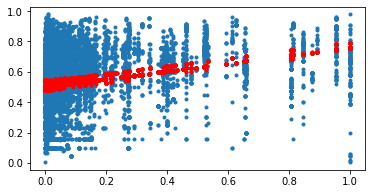

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(OrderModel_X1['End_Customer_Revenue'], OrderModel_y, ".")
plt.plot(OrderModel_X1['End_Customer_Revenue'], ORDERy_pred1, "r.")

In [57]:
#### Confidence interval

# calculate the standard deviation of y-pred values
ORDERy_pred_std1 = np.sqrt(sum((ORDERy_pred1-OrderModel_y)**2)/(len(OrderModel_y)-2))
ORDERy_pred_upper1 = ORDERy_pred1 + 1.036*ORDERy_pred_std1
ORDERy_pred_lower1 = ORDERy_pred1 - 1.036*ORDERy_pred_std1 
ORDERy_pred_upper1

array([0.70599379, 0.74499526, 0.70861831, ..., 0.84240737, 0.68334975,
       0.7396852 ])

In [58]:
ORDERy_pred1

array([0.50152588, 0.54052734, 0.50415039, ..., 0.63793945, 0.47888184,
       0.53521729])

In [59]:
OrderModel_Interval1 = OrderModel.loc[:,OrderModel.columns !='Average_Discount_Per_Sales_Rep']
OrderModel_Interval1['End_Customer_Revenue-Original'] = Not_normalized_revenue
OrderModel_Interval1['Predicted_Average_Discount_Per_Order'] = ORDERy_pred1
OrderModel_Interval1['Predicted_Lower_Average_Discount_Per_Order'] = ORDERy_pred_lower1
OrderModel_Interval1['Predicted_Upper_Average_Discount_Per_Order'] = ORDERy_pred_upper1
OrderModel_Interval1.head(3)

,End_Customer_Revenue,Average_Discount_Per_Order,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,End_Customer_Revenue-Original,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order
Sales Order Number,,,,,,,,,,,,
107451,0.004933,0.45,0,0,0,1,0,0,240780,0.501526,0.297058,0.705994
115174,0.156951,0.50,0,0,0,1,0,0,7656869,0.540527,0.336059,0.744995
121673,0.015227,0.45,0,0,0,1,0,0,742958,0.504150,0.299682,0.708618


In [60]:
# if the predicted disoucnt > upper bond then it will be an outlier
outlier1=[]
for i in range(0,len(ORDERy_pred_upper1)):
    if OrderModel_Interval1['Average_Discount_Per_Order'].tolist()[i] > ORDERy_pred_upper1[i]:
        outlier1.append(1)
    else:
        outlier1.append(0)
outlier1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


In [61]:
OrderModel_Interval1['Sales_Order_Outlier'] = outlier1
OrderModel_Interval1.head(2)

,End_Customer_Revenue,Average_Discount_Per_Order,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,End_Customer_Revenue-Original,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order,Sales_Order_Outlier
Sales Order Number,,,,,,,,,,,,,
107451,0.004933,0.45,0,0,0,1,0,0,240780,0.501526,0.297058,0.705994,0
115174,0.156951,0.50,0,0,0,1,0,0,7656869,0.540527,0.336059,0.744995,0


In [62]:
OrderModel_Interval1.to_csv("z-OrderModelResults_Revenue&Continent.csv")

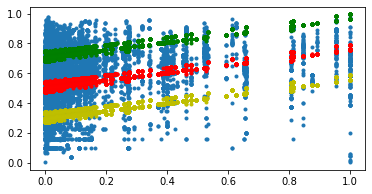

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(OrderModel_X1['End_Customer_Revenue'], OrderModel_y, ".")
plt.plot(OrderModel_X1['End_Customer_Revenue'], ORDERy_pred1, "r.")
plt.plot(OrderModel_X1['End_Customer_Revenue'], ORDERy_pred_upper1, "g.")
plt.plot(OrderModel_X1['End_Customer_Revenue'], ORDERy_pred_lower1, "y.")

### 3. Linear Regression Model - all included (revenue + continent + sales rep email)

In [64]:
from sklearn.linear_model import LinearRegression
OrderModel_X2.head(2)

,End_Customer_Revenue,Average_Discount_Per_Sales_Rep,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
Sales Order Number,,,,,,,,
107451,0.004933,0.531218,0,0,0,1,0,0
115174,0.156951,0.531218,0,0,0,1,0,0


In [65]:
ORDERreg2 = LinearRegression()
ORDERreg2.fit(OrderModel_X2, OrderModel_y)
ORDERy_pred2 = ORDERreg2.predict(OrderModel_X2)
ORDERreg2.score(OrderModel_X2, OrderModel_y) # R2

0.2771649606275842

In [66]:
from sklearn.metrics import mean_squared_error
mean_squared_error(OrderModel_y, ORDERy_pred2)

0.030985490273865914

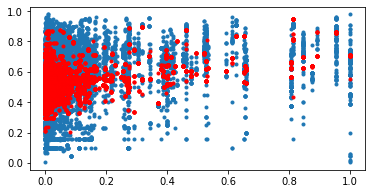

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(OrderModel_X2['End_Customer_Revenue'], OrderModel_y, ".")
plt.plot(OrderModel_X2['End_Customer_Revenue'], ORDERy_pred2, "r.")

#### Confidence Interval

In [68]:
# calculate the standard deviation of y-pred values
ORDERy_pred_std2 = np.sqrt(sum((ORDERy_pred2-OrderModel_y)**2)/(len(OrderModel_y)-2))
ORDERy_pred_upper2 = ORDERy_pred2 + 1.036*ORDERy_pred_std2 
ORDERy_pred_lower2 = ORDERy_pred2 - 1.036*ORDERy_pred_std2 
ORDERy_pred_upper2

array([0.6983301 , 0.71533699, 0.55902529, ..., 0.74273503, 0.5840857 ,
       0.69295992])

In [69]:
ORDERy_pred2

array([0.51595323, 0.53296012, 0.37664842, ..., 0.56035815, 0.40170882,
       0.51058304])

In [73]:
OrderModel_Interval2 = OrderModel
OrderModel_Interval2['End_Customer_Revenue-Original'] = Not_normalized_revenue
OrderModel_Interval2['Predicted_Average_Discount_Per_Order'] = ORDERy_pred2
OrderModel_Interval2['Predicted_Lower_Average_Discount_Per_Order'] = ORDERy_pred_lower2
OrderModel_Interval2['Predicted_Upper_Average_Discount_Per_Order'] = ORDERy_pred_upper2
OrderModel_Interval2.head(3)

,End_Customer_Revenue,Average_Discount_Per_Sales_Rep,Average_Discount_Per_Order,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order,Sales_Order_Outlier,End_Customer_Revenue-Original
Sales Order Number,,,,,,,,,,,,,,
107451,0.004933,0.531218,0.45,0,0,0,1,0,0,0.515953,0.333576,0.698330,0,240780
115174,0.156951,0.531218,0.50,0,0,0,1,0,0,0.532960,0.350583,0.715337,0,7656869
121673,0.015227,0.379636,0.45,0,0,0,1,0,0,0.376648,0.194272,0.559025,0,742958


In [74]:
# if the predicted disoucnt > upper bond then it will be an outlier
outlier2=[]
for i in range(0,len(ORDERy_pred_upper2)):
    if OrderModel_Interval2['Average_Discount_Per_Order'].tolist()[i] > ORDERy_pred_upper2[i]:
        outlier2.append(1)
    else:
        outlier2.append(0)
outlier2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


In [75]:
OrderModel_Interval2['Sales_Order_Outlier'] = outlier2
OrderModel_Interval2.head(2)

,End_Customer_Revenue,Average_Discount_Per_Sales_Rep,Average_Discount_Per_Order,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Predicted_Average_Discount_Per_Order,Predicted_Lower_Average_Discount_Per_Order,Predicted_Upper_Average_Discount_Per_Order,Sales_Order_Outlier,End_Customer_Revenue-Original
Sales Order Number,,,,,,,,,,,,,,
107451,0.004933,0.531218,0.45,0,0,0,1,0,0,0.515953,0.333576,0.698330,0,240780
115174,0.156951,0.531218,0.50,0,0,0,1,0,0,0.532960,0.350583,0.715337,0,7656869


In [76]:
OrderModel_Interval2.to_csv("z-OrderModelResults_Revenue&Continent&SalesRep.csv")

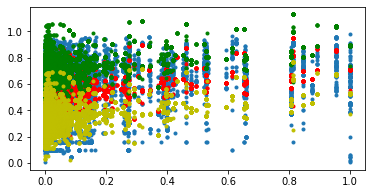

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(OrderModel_X2['End_Customer_Revenue'], OrderModel_y, ".")
plt.plot(OrderModel_X2['End_Customer_Revenue'], ORDERy_pred2, "r.")
plt.plot(OrderModel_X2['End_Customer_Revenue'], ORDERy_pred_upper2, "g.")
plt.plot(OrderModel_X2['End_Customer_Revenue'], ORDERy_pred_lower2, "y.")

## Per End Customer
Data for other models:
1. End customer without continent
2. End customer with continent

### 1. End Customer without Continent

#### Discount

In [18]:
end_customer_discount = sales.groupby("End Customer Parent Name")["DISCOUNT"].agg(["mean"])
end_customer_discount

,mean
End Customer Parent Name,
1&1 Drillisch AG,0.749950
10X Genomics (ANL),0.311450
112 Emergency Call Center,0.784878
11ST,0.581825
11th Judicial Circuit,0.160000
...,...
vPay,0.337214
velia.net Internetdienste GmbH (GoDaddy Germany),0.589343
vitroconnect GmbH,0.656905


In [19]:
# exclude the direct sales rows (but include indirect sales when calculat the mean discount)
end_customer_discount2 = sales3.groupby("End Customer Parent Name")["DISCOUNT"].agg(["mean"])
end_customer_discount2

,mean
End Customer Parent Name,
1&1 Drillisch AG,0.749950
112 Emergency Call Center,0.784878
11ST,0.581825
11th Judicial Circuit,0.160000
14257 Novartis U.S,0.726167
...,...
skylifetv,0.664444
vPay,0.337214
vitroconnect GmbH,0.656905


In [20]:
sum(end_customer_discount['mean'])

2119.4748968754725

In [21]:
# end_customer_discount2 includes only the indirect sale end customers by include both direct and indirect revenues 
end_customer_discount2['mean'] = [end_customer_discount['mean'][i] for i in end_customer_discount2.index.tolist()]
sum(end_customer_discount2['mean'])

1942.454072171476

In [22]:
end_customer_discount2.head(2)

,mean
End Customer Parent Name,
1&1 Drillisch AG,0.749950
112 Emergency Call Center,0.784878


#### End customer revenue

In [23]:
end_customer_revenue_ = sales.groupby("End Customer Parent Name")["End Customer Revenue_List Price"].unique()
end_customer_revenue_ = [i[0] for i in end_customer_revenue_]
end_customer_revenue_ = pd.DataFrame(end_customer_revenue_, index = end_customer_discount.index, columns = ["Revenue"])
end_customer_revenue_

,Revenue
End Customer Parent Name,
1&1 Drillisch AG,353760
10X Genomics (ANL),8482
112 Emergency Call Center,2461364
11ST,110941
11th Judicial Circuit,8250
...,...
vPay,226116
velia.net Internetdienste GmbH (GoDaddy Germany),206965
vitroconnect GmbH,827250


In [24]:
# extract the revenue based on the indirect end customer index
end_customer_discount2['Revenue'] = [end_customer_revenue_['Revenue'][i] for i in end_customer_discount2.index.tolist()]
EndCustomerModel=end_customer_discount2
Not_normalized_revenue = end_customer_discount2['Revenue']
EndCustomerModel

,mean,Revenue
End Customer Parent Name,,
1&1 Drillisch AG,0.749950,353760
112 Emergency Call Center,0.784878,2461364
11ST,0.581825,110941
11th Judicial Circuit,0.160000,8250
14257 Novartis U.S,0.726167,353212
...,...,...
skylifetv,0.664444,26309
vPay,0.337214,226116
vitroconnect GmbH,0.656905,827250


#### Normalize the revenue: rescale to range(0,1)

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
revenue = np.array(EndCustomerModel["Revenue"]).reshape(-1,1)
scaler = MinMaxScaler()
norm_revenue = scaler.fit_transform(revenue)
norm_revenue

array([[0.00737365],
       [0.0513156 ],
       [0.00231106],
       ...,
       [0.01724556],
       [0.00012493],
       [0.00193606]])

In [26]:
EndCustomerModel["Revenue-norm"] = norm_revenue
EndCustomerModel.columns = ['Average_Discount_End_Customer','End_Customer_Revenue-original','End_Customer_Revenue']
EndCustomerModel.head(2)

,Average_Discount_End_Customer,End_Customer_Revenue-original,End_Customer_Revenue
End Customer Parent Name,,,
1&1 Drillisch AG,0.749950,353760,0.007374
112 Emergency Call Center,0.784878,2461364,0.051316


In [27]:
EndCustomerModel.to_csv('z-EndCustomer_Kcluster_Input_8-17-2021.csv')

#### Linear Regression Model

In [106]:
import numpy as np
EndCustomerModel_X=np.array(EndCustomerModel['Revenue'])
EndCustomerModel_X=EndCustomerModel_X.reshape(-1, 1)
EndCustomerModel_y=EndCustomerModel['mean']
EndCustomerModel_X

array([[0.0199733 ],
       [0.00227189],
       [0.0001669 ],
       ...,
       [0.00409933],
       [0.01312828],
       [0.00012256]])

In [107]:
EndCustomerModel_y

End Customer Parent Name
112 Emergency Call Center    0.771727
11ST                         0.581825
11th Judicial Circuit        0.160000
14257 Novartis U.S           0.682500
23andMe                      0.608000
                               ...   
myLoc managed IT AG          0.230000
skylifetv                    0.621667
vPay                         0.395550
vitroconnect GmbH            0.649444
wittenberg-net GmbH          0.230000
Name: mean, Length: 3270, dtype: float64

In [108]:
EndCUSTreg = LinearRegression()
EndCUSTreg.fit(EndCustomerModel_X, EndCustomerModel_y)
EndCUSTy_pred = EndCUSTreg.predict(EndCustomerModel_X)
EndCUSTreg.score(EndCustomerModel_X, EndCustomerModel_y) # R2

0.043592156404857585

In [109]:
from sklearn.metrics import mean_squared_error
mean_squared_error(EndCustomerModel_X, EndCUSTy_pred)

0.19532841222935454

In [91]:
EndCUSTreg.coef_

array([0.58459539])

In [110]:
EndCUSTreg.intercept_

0.4483565714332248

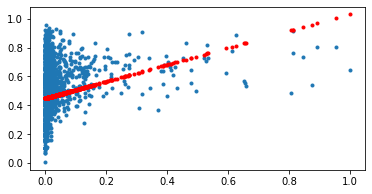

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,3))
plt.plot(EndCustomerModel_X, EndCustomerModel_y, ".")
plt.plot(EndCustomerModel_X, EndCUSTy_pred, "r.")

In [112]:
# calculate the standard deviation of y-pred values
EndCUSTy_pred_std = np.sqrt(sum((EndCUSTy_pred-EndCustomerModel_y)**2)/(len(EndCustomerModel_y)-2))
EndCUSTy_pred_upper = EndCUSTy_pred + 1.036*EndCUSTy_pred_std 
EndCUSTy_pred_lower = EndCUSTy_pred - 1.036*EndCUSTy_pred_std 
EndCUSTy_pred_upper

array([0.65773713, 0.64738896, 0.6461584 , ..., 0.64845728, 0.65373556,
       0.64613248])

In [113]:
EndCUSTy_pred

array([0.46003287, 0.44968471, 0.44845414, ..., 0.45075302, 0.4560313 ,
       0.44842822])

In [114]:
EndCustomerModel.columns = ['Average_Discount_Per_End_Customer','End_Customer_Revenue']
EndCustomerModel.head(2)

,Average_Discount_Per_End_Customer,End_Customer_Revenue
End Customer Parent Name,,
112 Emergency Call Center,0.771727,0.019973
11ST,0.581825,0.002272


In [115]:
EndCustomerModel_Interval = EndCustomerModel
EndCustomerModel_Interval['End_Customer_Revenue-Original'] = Not_normalized_revenue
EndCustomerModel_Interval['Predicted_Average_Discount_End_Customer'] = EndCUSTy_pred
EndCustomerModel_Interval['Predicted_Lower_Average_Discount_End_Customer'] = EndCUSTy_pred_lower
EndCustomerModel_Interval['Predicted_Upper_Average_Discount_End_Customer'] = EndCUSTy_pred_upper
EndCustomerModel_Interval.head(3)

,Average_Discount_Per_End_Customer,End_Customer_Revenue,End_Customer_Revenue-Original,Predicted_Average_Discount_End_Customer,Predicted_Lower_Average_Discount_End_Customer,Predicted_Upper_Average_Discount_End_Customer
End Customer Parent Name,,,,,,
112 Emergency Call Center,0.771727,0.019973,974496,0.460033,0.262329,0.657737
11ST,0.581825,0.002272,110941,0.449685,0.251980,0.647389
11th Judicial Circuit,0.160000,0.000167,8250,0.448454,0.250750,0.646158


In [116]:
outlier3=[]
for i in range(0,len(EndCUSTy_pred)):
    if EndCustomerModel_Interval['Average_Discount_Per_End_Customer'].tolist()[i] > EndCUSTy_pred_upper[i]:
        outlier3.append(1)
    else:
        outlier3.append(0)

In [117]:
EndCustomerModel_Interval['End_Customer_Outlier'] = outlier3
EndCustomerModel_Interval.head(2)

,Average_Discount_Per_End_Customer,End_Customer_Revenue,End_Customer_Revenue-Original,Predicted_Average_Discount_End_Customer,Predicted_Lower_Average_Discount_End_Customer,Predicted_Upper_Average_Discount_End_Customer,End_Customer_Outlier
End Customer Parent Name,,,,,,,
112 Emergency Call Center,0.771727,0.019973,974496,0.460033,0.262329,0.657737,1
11ST,0.581825,0.002272,110941,0.449685,0.251980,0.647389,0


In [118]:
EndCustomerModel_Interval.to_csv("z-EndCustomerModelResults_RevenueOnly.csv")

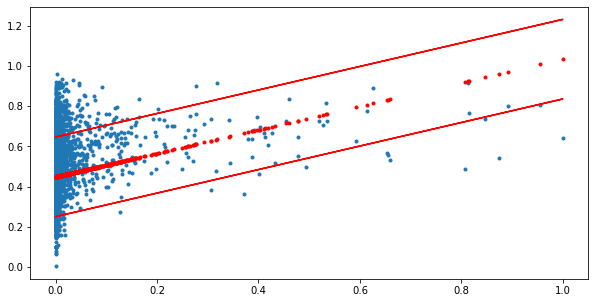

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.plot(EndCustomerModel_X, EndCustomerModel_y, ".")
plt.plot(EndCustomerModel_X, EndCUSTy_pred, "r.")
plt.plot(EndCustomerModel_X, EndCUSTy_pred_upper, "r-")
plt.plot(EndCustomerModel_X, EndCUSTy_pred_lower, "r-")

### 2. End Customer with Continent

#### Continent

In [120]:
# only include the indirect sales
end_customer_continent = sales3.groupby("End Customer Parent Name")["Continent"].unique()
end_customer_continent

End Customer Parent Name
112 Emergency Call Center             [Asia]
11ST                                  [Asia]
11th Judicial Circuit        [North America]
14257 Novartis U.S           [North America]
23andMe                      [North America]
                                  ...       
myLoc managed IT AG                 [Europe]
skylifetv                             [Asia]
vPay                         [North America]
vitroconnect GmbH                   [Europe]
wittenberg-net GmbH                 [Europe]
Name: Continent, Length: 3270, dtype: object

#### Multiple continents for the end customer

In [121]:
multipleContinent = 0
for index, i in zip(end_customer_continent.index, end_customer_continent):
    if len(i) > 1:
        print(index, i)
        multipleContinent += 1
print(multipleContinent)

ABSA Bank ['Africa' 'Europe']
ADP ['North America' 'Europe']
Accenture LLP ['Europe' 'North America']
AfterPay ['North America' 'Oceania' 'Asia']
Agoda ['Asia' 'Europe']
Amadeus ['North America' 'Europe']
Amazon ['North America' 'Europe']
American Express Company ['Asia' 'North America' 'Europe']
American International Group (AIG) ['Asia' 'North America' 'Europe']
Applied Materials ['North America' 'Europe' 'Asia']
Ascenty ['South America' 'North America']
Autodesk ['North America' 'Asia']
BGC Partners (US) ['North America' 'Europe']
BMW Group ['Asia' 'Europe']
BNP Paribas ['Oceania' 'Asia' 'Europe' 'North America']
BackBlaze ['North America' 'Europe']
Bambora ['Oceania' 'North America']
Barclays ['Asia' 'North America' 'Europe']
Belden Inc. ['North America' 'Europe']
Bharti Airtel ['Asia' 'Europe']
BidFX ['North America' 'Europe']
Bigo Technology Pte Ltd ['Asia' 'North America']
Bookings Holdings  Inc. ['North America' 'Europe']
Box, Inc. ['North America' 'Europe']
Buckeye Broadband I

#### Join the continent, revenue and discount per end customer

In [125]:
EndCustomerModel_continent = pd.concat([EndCustomerModel[['End_Customer_Revenue','Average_Discount_Per_End_Customer']], end_customer_continent], axis=1)
EndCustomerModel_continent.head(5)

,End_Customer_Revenue,Average_Discount_Per_End_Customer,Continent
End Customer Parent Name,,,
112 Emergency Call Center,0.019973,0.771727,[Asia]
11ST,0.002272,0.581825,[Asia]
11th Judicial Circuit,0.000167,0.160000,[North America]
14257 Novartis U.S,0.000848,0.682500,[North America]
23andMe,0.002626,0.608000,[North America]


#### Create dummy variables for continent using one hot encoding

In [126]:
m2_continent = EndCustomerModel_continent['Continent'].str.join(sep='*').str.get_dummies(sep='*')
m2_continent

,Africa,Asia,Europe,North America,Oceania,South America
End Customer Parent Name,,,,,,
112 Emergency Call Center,0,1,0,0,0,0
11ST,0,1,0,0,0,0
11th Judicial Circuit,0,0,0,1,0,0
14257 Novartis U.S,0,0,0,1,0,0
23andMe,0,0,0,1,0,0
...,...,...,...,...,...,...
myLoc managed IT AG,0,0,1,0,0,0
skylifetv,0,1,0,0,0,0
vPay,0,0,0,1,0,0


In [127]:
EndCustomerModel_continent = pd.concat([EndCustomerModel_continent, m2_continent], axis = 1).drop("Continent", axis = 1)
EndCustomerModel_continent.head(5)

,End_Customer_Revenue,Average_Discount_Per_End_Customer,Africa,Asia,Europe,North America,Oceania,South America
End Customer Parent Name,,,,,,,,
112 Emergency Call Center,0.019973,0.771727,0,1,0,0,0,0
11ST,0.002272,0.581825,0,1,0,0,0,0
11th Judicial Circuit,0.000167,0.160000,0,0,0,1,0,0
14257 Novartis U.S,0.000848,0.682500,0,0,0,1,0,0
23andMe,0.002626,0.608000,0,0,0,1,0,0


In [128]:
EndCustomerModel_continent.to_csv("z-EndCustomerModelResults_NormalizedData.csv")

#### Linear Regression Model

In [129]:
import numpy as np
EndCustomerModel_continent_y=EndCustomerModel_continent['Average_Discount_Per_End_Customer']
EndCustomerModel_continent_X=EndCustomerModel_continent.loc[:,EndCustomerModel_continent.columns !='Average_Discount_Per_End_Customer']
EndCustomerModel_continent_X.head(2)

,End_Customer_Revenue,Africa,Asia,Europe,North America,Oceania,South America
End Customer Parent Name,,,,,,,
112 Emergency Call Center,0.019973,0,1,0,0,0,0
11ST,0.002272,0,1,0,0,0,0


In [130]:
reg3 = LinearRegression()
reg3.fit(EndCustomerModel_continent_X, EndCustomerModel_continent_y)
y_pred3 = reg3.predict(EndCustomerModel_continent_X)
reg3.score(EndCustomerModel_continent_X, EndCustomerModel_continent_y) # R2

0.07922090271508808

In [131]:
from sklearn.metrics import mean_squared_error
mean_squared_error(EndCustomerModel_continent_y, y_pred3)

0.035039601084712386

In [132]:
reg3.coef_

array([ 0.57346638, -0.01929361,  0.06386559,  0.00579671, -0.02650982,
       -0.02200628, -0.01895496])

In [133]:
reg3.intercept_

0.44340112767950657

In [134]:
# calculate the standard deviation of y-pred values
y_pred3_std = np.sqrt(sum((y_pred3-EndCustomerModel_continent_y)**2)/(len(EndCustomerModel_continent_y)-2))
y_pred3_upper = y_pred3 + 1.036*y_pred3_std 
y_pred3_lower = y_pred3 - 1.036*y_pred3_std 
y_pred3_upper

array([0.71270754, 0.70255637, 0.61097382, ..., 0.61322894, 0.65071327,
       0.64325492])

In [135]:
y_pred3

array([0.51872074, 0.50856957, 0.41698701, ..., 0.41924213, 0.45672646,
       0.44926812])

In [136]:
EndCustomerModel_continent_Interval = EndCustomerModel_continent
EndCustomerModel_continent_Interval ['End_Customer_Revenue-Original'] = Not_normalized_revenue
EndCustomerModel_continent_Interval['Predicted_Average_Discount_End_Customer'] = y_pred3
EndCustomerModel_continent_Interval['Predicted_Lower_Average_Discount_End_Customer'] = y_pred3_lower
EndCustomerModel_continent_Interval['Predicted_Upper_Average_Discount_End_Customer'] = y_pred3_upper
EndCustomerModel_continent_Interval.head(3)

,End_Customer_Revenue,Average_Discount_Per_End_Customer,Africa,Asia,Europe,North America,Oceania,South America,End_Customer_Revenue-Original,Predicted_Average_Discount_End_Customer,Predicted_Lower_Average_Discount_End_Customer,Predicted_Upper_Average_Discount_End_Customer
End Customer Parent Name,,,,,,,,,,,,
112 Emergency Call Center,0.019973,0.771727,0,1,0,0,0,0,974496,0.518721,0.324734,0.712708
11ST,0.002272,0.581825,0,1,0,0,0,0,110941,0.508570,0.314583,0.702556
11th Judicial Circuit,0.000167,0.160000,0,0,0,1,0,0,8250,0.416987,0.223000,0.610974


In [137]:
outlier4=[]
for i in range(0,len(y_pred3)):
    if EndCustomerModel_continent_Interval['Average_Discount_Per_End_Customer'].tolist()[i] > y_pred3_upper[i]:
        outlier4.append(1)
    else:
        outlier4.append(0)

In [138]:
EndCustomerModel_continent_Interval['End_Customer_Outlier'] = outlier4
EndCustomerModel_continent_Interval.head(2)

,End_Customer_Revenue,Average_Discount_Per_End_Customer,Africa,Asia,Europe,North America,Oceania,South America,End_Customer_Revenue-Original,Predicted_Average_Discount_End_Customer,Predicted_Lower_Average_Discount_End_Customer,Predicted_Upper_Average_Discount_End_Customer,End_Customer_Outlier
End Customer Parent Name,,,,,,,,,,,,,
112 Emergency Call Center,0.019973,0.771727,0,1,0,0,0,0,974496,0.518721,0.324734,0.712708,1
11ST,0.002272,0.581825,0,1,0,0,0,0,110941,0.508570,0.314583,0.702556,0


In [139]:
EndCustomerModel_continent_Interval.to_csv("z-EndCustomerModelResults_Revenue&Continent.csv")

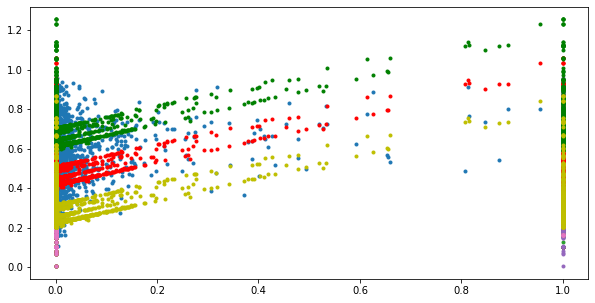

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.plot(EndCustomerModel_continent_X, EndCustomerModel_continent_y, ".")
plt.plot(EndCustomerModel_continent_X, y_pred3, "r.")
plt.plot(EndCustomerModel_continent_X, y_pred3_upper, "g.")
plt.plot(EndCustomerModel_continent_X, y_pred3_lower, "y.")